Sessa Empirical Estimator (SEE) – Reproduction & Extension in Python

**Dataset:**  
This notebook uses the [AdhereR | med.events](https://rdrr.io/cran/AdhereR/man/med.events.html) dataset saved at `../data/tidy_dataset.csv`. The dataset has the following columns:

- **pnr:** Patient ID
- **eksd:** Medication event date (YYYY-MM-DD)
- **perday:** Daily dosage (not used in SEE)
- **ATC:** Medication type (e.g. "medA" or "medB")
- **dur_original:** Original prescription duration (not used in SEE)

**Overview of the SEE Steps (following the paper):**

1. **ECDF & Outlier Removal:**  
   Compute the temporal distances between consecutive fills for all patients, build the ECDF, and retain only the lower 80% to remove artificially long gaps.

2. **Random Pair Selection:**  
   For each patient, randomly select one pair of consecutive fills from the 80% subset to avoid over‐representation of frequent refillers.

3. **Standardization & Clustering:**  
   Standardize the selected temporal distances and cluster them.

4. **Density Estimation & Computed Duration:**  
   For each cluster, compute the median temporal distance (as a robust estimate of the prescription duration).

5. **Compute End‑of‑Supply:**  
   For each randomly selected pair, compute the end‑of‑supply date by adding the computed duration to the later fill date.

In this notebook, we implement and compare two clustering approaches: K‑Means (with silhouette analysis to choose the optimal number of clusters) and DBSCAN (with a parameter search to find the best eps and min_samples).
Finally, we compare the clustering outcomes using various visualizations (ECDF plots, density plots, and boxplots).

## Loading the Dataset

We load the dataset and parse the `eksd` column.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load dataset (assumes your file is located at ../data/tidy_dataset.csv)
med_events_df = pd.read_csv('../data/tidy_dataset.csv', parse_dates=['eksd'])
# Rename columns to match our code
med_events_df.rename(columns={'eksd': 'DATE', 'perday': 'PERDAY', 'pnr': 'PATIENT_ID', 'dur_original': 'DURATION'}, inplace=True)

print("Dataset columns:", med_events_df.columns.tolist())
print("First few rows:")
print(med_events_df.head())

def compute_event_interval(df):
    """
    For each patient, compute the difference (in days) between consecutive medication events.
    Returns a DataFrame with an added 'event_interval' column.
    """
    df = df.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    df['prev_DATE'] = df.groupby('PATIENT_ID')['DATE'].shift(1)
    df = df.dropna(subset=['prev_DATE'])
    df['event_interval'] = (df['DATE'] - df['prev_DATE']).dt.days
    return df

# Filter for a chosen medication type (e.g., medA) and compute event intervals
df_medA = med_events_df[med_events_df['ATC'] == 'medA'].copy()
df_medA = compute_event_interval(df_medA)


Dataset columns: ['PATIENT_ID', 'DATE', 'PERDAY', 'ATC', 'DURATION']
First few rows:
   PATIENT_ID       DATE  PERDAY   ATC  DURATION
0           1 2033-04-26       4  medA        50
1           1 2033-07-04       4  medB        30
2           1 2033-08-03       4  medB        30
3           1 2033-08-17       4  medB        30
4           1 2033-10-13       4  medB        30


## Step 1: ECDF Computation & Outlier Removal

**Objective:** Compute the event intervals (days between consecutive medication events) for each patient,
then build the ECDF and retain only the lower 80% of the distribution.

We show both:

The full (100%) ECDF
The 80% ECDF (retaining only the lower 80% of values)

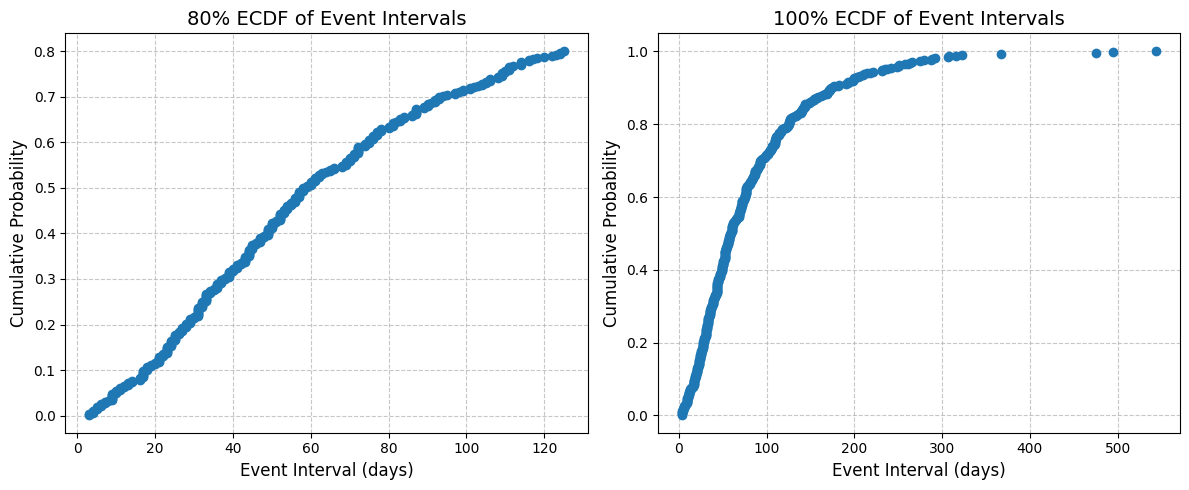

80th percentile threshold (ni) for medA = 125 days


In [117]:
def empirical_cdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def plot_both_ecdfs(df):
    x_full, y_full = empirical_cdf(df['event_interval'])
    df_ecdf = pd.DataFrame({'event_interval': x_full, 'cdf': y_full})
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['event_interval'], df_ecdf_80['cdf'], marker='o', linestyle='None')
    plt.title('80% ECDF of Event Intervals', fontsize=14)
    plt.xlabel('Event Interval (days)', fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['event_interval'], df_ecdf['cdf'], marker='o', linestyle='None')
    plt.title('100% ECDF of Event Intervals', fontsize=14)
    plt.xlabel('Event Interval (days)', fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Return the 80% threshold (ni)
    ni = df_ecdf_80['event_interval'].max()
    return ni

# Plot ECDFs for medA
ni_medA = plot_both_ecdfs(df_medA)
print(f"80th percentile threshold (ni) for medA = {ni_medA} days")


## Step 2: Random Pair Selection

**Objective:** From the subset of consecutive events (after outlier removal), select one random pair per patient.

In [130]:
import warnings
warnings.filterwarnings("ignore")

def random_pair_selection(df):
    """
    For each patient, randomly selects one row (i.e., one consecutive event pair)
    from the provided dataframe.
    """
    random_pairs = df.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    return random_pairs

# Apply random pair selection:
df_random = random_pair_selection(df_subset)
print("Randomly selected pairs (first few rows):")
print(df_random.head())


Randomly selected pairs (first few rows):
   pnr       eksd  perday   ATC  dur_original  prev_eksd  event_interval
0    2 2036-03-10       4  medA            50 2036-01-20              50
1    4 2033-08-30       4  medA            50 2033-08-20              10
2    5 2032-01-25       8  medA            30 2031-12-27              29
3    6 2037-03-24       4  medA            50 2037-01-07              76
4    7 2043-06-03       2  medA           100 2043-03-18              77


### Density Plot

We subset the data to include only events with event_interval ≤ ni (the lower 80% of the distribution), then plot the density of the log-transformed event intervals.
The plot is annotated with the number of points (N) and the bandwidth used.

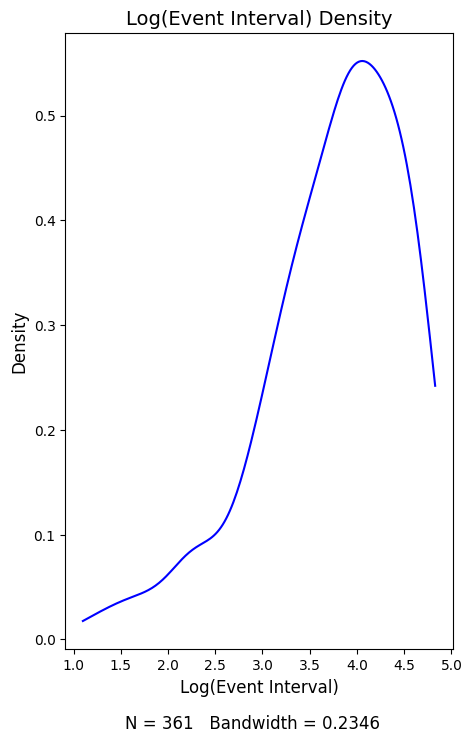

In [131]:
# Subset to lower 80% of event intervals
df_medA_subset = df_medA[df_medA['event_interval'] <= ni_medA].copy()
if df_medA_subset.empty:
    print("No data in the 80% range. Using full dataset for density estimation.")
    df_medA_subset = df_medA.copy()

# Density plot of log-transformed event intervals
positive_intervals = df_medA_subset['event_interval'][df_medA_subset['event_interval'] > 0]
if len(positive_intervals) < 2:
    print("Not enough positive event intervals for density estimation.")
else:
    log_intervals = np.log(positive_intervals)
    try:
        density = gaussian_kde(log_intervals)
    except Exception as e:
        print("Error computing density:", e)
    else:
        x_density = np.linspace(log_intervals.min(), log_intervals.max(), 200)
        y_density = density(x_density)
        bandwidth = density.factor * log_intervals.std(ddof=1)
        n_points = len(log_intervals)
        plt.figure(figsize=(5, 8))
        plt.plot(x_density, y_density, color='blue')
        plt.title('Log(Event Interval) Density', fontsize=14)
        plt.xlabel('Log(Event Interval)', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.figtext(0.5, 0.01, f'N = {n_points}   Bandwidth = {bandwidth:.4f}', ha='center', fontsize=12)
        plt.show()


## Step 3: Standardization & Clustering

### 3a. K‑Means Clustering
We standardize the event intervals from the 80% subset, use silhouette analysis to determine the optimal number of clusters, and apply K‑Means clustering.
The optimal number of clusters is printed, and a boxplot of event intervals by prescription order (p_number) is produced to show the distribution.

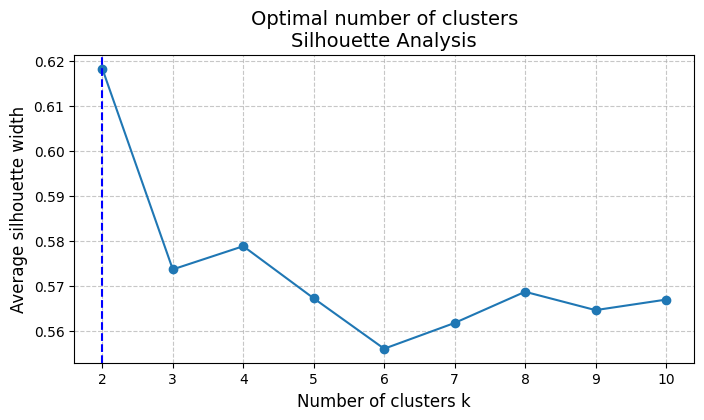

Optimal number of clusters (K-Means) for medA: 2


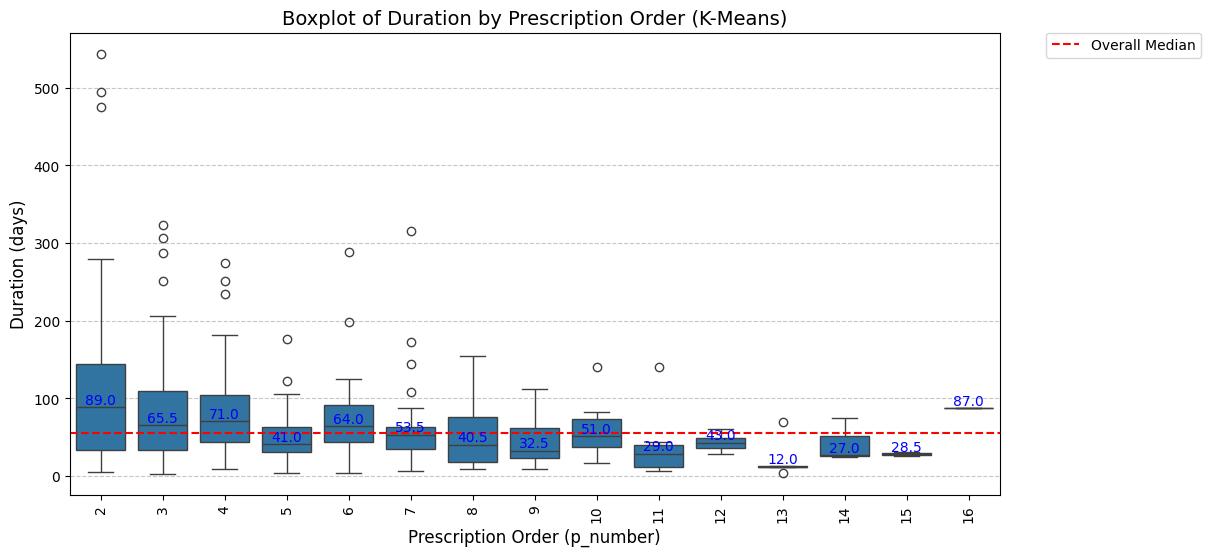

In [132]:
def optimal_kmeans_silhouette(X, k_min=2, k_max=10):
    k_values = range(k_min, k_max + 1)
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    best_k = k_values[np.argmax(silhouette_scores)]
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
    plt.axvline(x=best_k, color='blue', linestyle='--')
    plt.title('Optimal number of clusters\nSilhouette Analysis', fontsize=14)
    plt.xlabel('Number of clusters k', fontsize=12)
    plt.ylabel('Average silhouette width', fontsize=12)
    plt.xticks(list(k_values))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return best_k

# Standardize and cluster using K-Means
scaler = StandardScaler()
X_km = scaler.fit_transform(df_medA_subset[['event_interval']])
if len(X_km) < 2:
    print("Not enough data for clustering with K-Means.")
else:
    optimal_k = optimal_kmeans_silhouette(X_km)
    print(f"Optimal number of clusters (K-Means) for medA: {optimal_k}")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_medA_subset['Cluster'] = kmeans.fit_predict(X_km)
    
    # Boxplot by prescription order (p_number)
    df_medA_sorted = df_medA.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    df_medA_sorted['p_number'] = df_medA_sorted.groupby('PATIENT_ID').cumcount() + 1
    df_medA_filtered = df_medA_sorted[df_medA_sorted['p_number'] >= 2].copy()
    
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x='p_number', y='event_interval', data=df_medA_filtered)
    plt.xticks(rotation=90)
    overall_median = df_medA_filtered['event_interval'].median()
    plt.axhline(y=overall_median, color='red', linestyle='--', label='Overall Median')
    medians = df_medA_filtered.groupby('p_number')['event_interval'].median()
    for i, median_val in enumerate(medians):
        ax.text(i, median_val, f'{median_val:.1f}', ha='center', va='bottom', color='blue', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Boxplot of Duration by Prescription Order (K-Means)', fontsize=14)
    plt.xlabel('Prescription Order (p_number)', fontsize=12)
    plt.ylabel('Duration (days)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


## Step 4: Density Estimation & Computation of Prescription Duration

**Objective:** For each cluster, compute the median event interval which serves as the computed prescription duration.

Cluster median (computed) durations:
   Cluster  Computed_Duration
0        0               37.5
1        1               99.0
Cluster median (computed) durations:
   Cluster  Computed_Duration
0        0               45.0
1        1              109.0


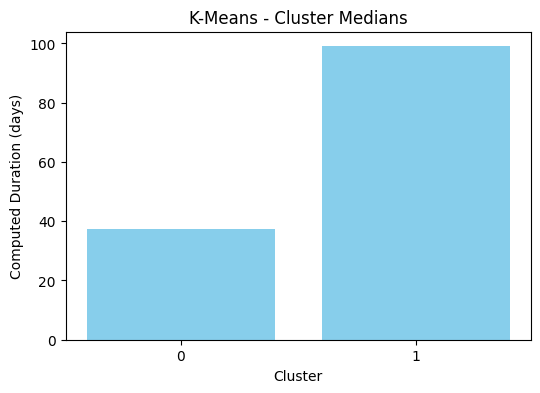

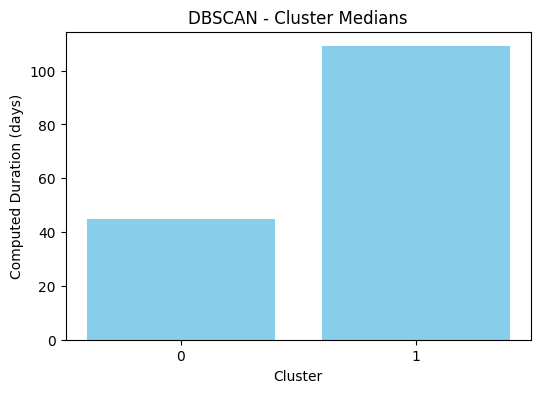

In [156]:
import matplotlib.pyplot as plt

def plot_cluster_medians(cluster_medians, method_name="Clustering"):
    """
    Plots a bar chart of computed cluster medians.
    
    Parameters
    ----------
    cluster_medians : pd.DataFrame
        DataFrame with columns 'Cluster' and 'Computed_Duration'
    method_name : str, optional
        Title to display in the chart.
    """
    plt.figure(figsize=(6,4))
    # Convert the cluster labels to string for nicer x-axis labels.
    plt.bar(cluster_medians['Cluster'].astype(str), cluster_medians['Computed_Duration'], color='skyblue')
    plt.xlabel("Cluster")
    plt.ylabel("Computed Duration (days)")
    plt.title(f"{method_name} - Cluster Medians")
    plt.show()

# Assuming km_cluster_medians and db_cluster_medians have been computed as:
km_cluster_medians = compute_cluster_medians(df_random_km)
db_cluster_medians = compute_cluster_medians(df_best)

# Plot for K-Means clusters
plot_cluster_medians(km_cluster_medians, method_name="K-Means")

# Plot for DBSCAN clusters
plot_cluster_medians(db_cluster_medians, method_name="DBSCAN")

## Step 5: Compute End‑of‑Supply Date

**Objective:** For each randomly selected pair, add the computed duration (from its cluster) to the later prescription date.

In [139]:
import pandas as pd

def compute_end_of_supply(df, cluster_medians):
    """
    Merges the computed cluster medians into the random pairs dataframe and computes the end-of-supply date.
    The end-of-supply date is calculated as the 'eksd' (of the later fill in the pair) plus the computed duration (in days).

    Parameters:
      df : DataFrame
          The random pairs DataFrame containing at least the columns 'pnr', 'eksd', 'event_interval', and 'Cluster'.
      cluster_medians : DataFrame
          A DataFrame with columns 'Cluster' and 'Computed_Duration' where Computed_Duration is the median event_interval for that cluster.
    
    Returns:
      df : DataFrame
          The input DataFrame with an added 'End_of_Supply' column.
    """
    # Merge the computed durations into the dataframe based on the 'Cluster' column.
    df = df.merge(cluster_medians, on='Cluster', how='left')
    # Compute the end-of-supply date by adding the computed duration (in days) to the event date (eksd)
    df['End_of_Supply'] = df['eksd'] + pd.to_timedelta(df['Computed_Duration'], unit='D')
    return df

# For example, assuming you have already computed:
# - df_random_km: random pairs DataFrame with K-Means clustering (with a 'Cluster' column)
# - km_cluster_medians: DataFrame mapping each K-Means cluster to its median event_interval (Computed_Duration)
# - df_random_db and db_cluster_medians similarly for DBSCAN

# Compute end-of-supply using K-Means clustering results:
df_random_km_supply = compute_end_of_supply(df_random_km, km_cluster_medians)
print("K-Means: End-of-Supply (first few rows):")
print(df_random_km_supply[['pnr', 'eksd', 'event_interval', 'Cluster', 'Computed_Duration', 'End_of_Supply']].head())

# Compute end-of-supply using DBSCAN clustering results:
df_best_db_supply = compute_end_of_supply(df_best, db_cluster_medians)
print("DBSCAN: End-of-Supply (first few rows):")
print(df_best_db_supply[['pnr', 'eksd', 'event_interval', 'Cluster', 'Computed_Duration', 'End_of_Supply']].head())

K-Means: End-of-Supply (first few rows):
   pnr       eksd  event_interval  Cluster  Computed_Duration  \
0    2 2036-03-10              50        0               37.5   
1    4 2033-12-17             109        1               99.0   
2    5 2032-03-04              39        0               37.5   
3    6 2037-03-24              76        1               99.0   
4    7 2042-07-30             116        1               99.0   

        End_of_Supply  
0 2036-04-16 12:00:00  
1 2034-03-26 00:00:00  
2 2032-04-10 12:00:00  
3 2037-07-01 00:00:00  
4 2042-11-06 00:00:00  
DBSCAN: End-of-Supply (first few rows):
   pnr       eksd  event_interval  Cluster  Computed_Duration End_of_Supply
0    2 2036-03-10              50        0               45.0    2036-04-24
1    4 2033-12-17             109        1              109.0    2034-04-05
2    5 2032-03-04              39        0               45.0    2032-04-18
3    6 2037-03-24              76        0               45.0    2037-05-08
4   

## Comparison of Clustering Methods

In this section, we compare the computed prescription durations from K‑Means and DBSCAN.
For example, we can compute the median event interval for each method and display them side by side as a bar chart or boxplot.

### Discussion Points:

How the choice of clustering method (K‑Means vs. DBSCAN) affects the computed duration.
The strengths and limitations of each approach in the context of the SEE methodology.
Implications for pharmacoepidemiologic research.

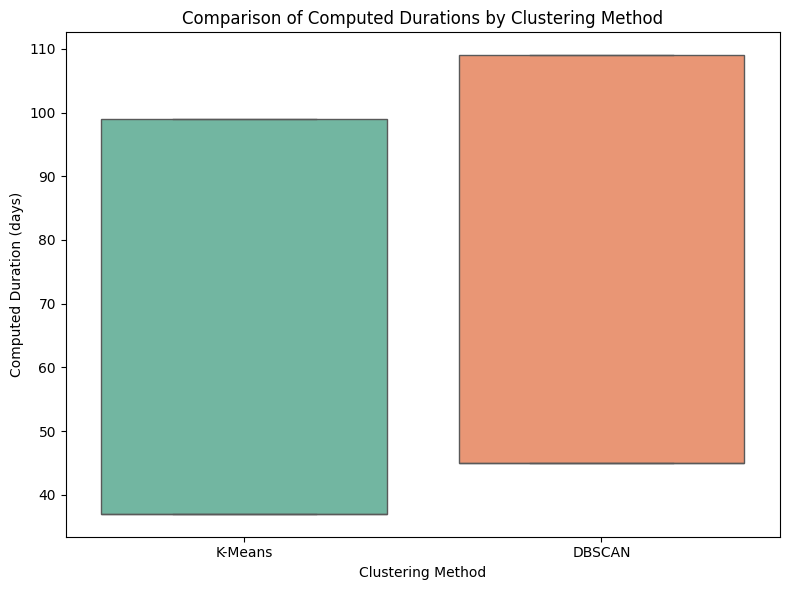

In [141]:
def compare_computed_durations_boxplot(df_km_supply, df_db_supply):
    """
    Combines the K-Means and DBSCAN end-of-supply results into one DataFrame
    and creates a boxplot comparing the computed durations (in days) for each method.
    
    Parameters
    ----------
    df_km_supply : pd.DataFrame
        DataFrame with K-Means results that includes columns 'eksd', 'End_of_Supply', etc.
    df_db_supply : pd.DataFrame
        DataFrame with DBSCAN results that includes columns 'eksd', 'End_of_Supply', etc.
    """
    # Make copies and add a "Method" column to distinguish between methods
    df_km = df_km_supply.copy()
    df_db = df_db_supply.copy()
    df_km["Method"] = "K-Means"
    df_db["Method"] = "DBSCAN"
    
    # Concatenate the two DataFrames
    df_compare = pd.concat([df_km, df_db], ignore_index=True)
    
    # Compute the computed duration as the difference (in days) between End_of_Supply and eksd
    df_compare["Computed_Duration_Diff"] = (df_compare["End_of_Supply"] - df_compare["eksd"]).dt.days
    
    # Create a boxplot comparing the computed durations for each method
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Method", y="Computed_Duration_Diff", data=df_compare, palette="Set2")
    plt.title("Comparison of Computed Durations by Clustering Method")
    plt.xlabel("Clustering Method")
    plt.ylabel("Computed Duration (days)")
    plt.tight_layout()
    plt.show()

compare_computed_durations_boxplot(df_random_km_supply, df_best_db_supply)